# DX 704 Week 2 Project

This week's project will analyze fresh strawberry price data for a hypothetical "buy low, freeze, and sell high" business.
Strawberries show strong seasonality in their prices compared to other fruits.

![](https://ers.usda.gov/sites/default/files/_laserfiche/Charts/61401/oct14_finding_plattner_fig01.png)

Image source: https://www.ers.usda.gov/amber-waves/2014/october/seasonal-fresh-fruit-price-patterns-differ-across-commodities-the-case-of-strawberries-and-apples

You are considering a business where you buy strawberries when the prices are very low, carefully freeze them, even more carefully defrost them, and then sell them when the prices are high.
You will forecast strawberry price time series and then use them to tactically pick times to buy, freeze, and sell the strawberries.

The full project description, a template notebook, and raw data are available on GitHub at the following link.

https://github.com/bu-cds-dx704/dx704-project-02


### Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Backtest Strawberry Prices

Read the provided "strawberry-prices.tsv" with data from 2020 through 2024.
This data is based on data from the U.S. Bureau of Statistics, but transformed so the ground truth is not online.
https://fred.stlouisfed.org/series/APU0000711415

Use the data for 2020 through 2023 to predict monthly prices in 2024.
Spend some time to make sure you are happy with your methodology and prediction accuracy, since you will reuse the methodology to forecast 2025 next.
Save the 2024 backtest predictions as "strawberry-backtest.tsv" with columns month and price.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.tsa.ar_model as ar_model
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [2]:
# Read in the tsv file
df = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\Module-6-Projects\dx704-project-02\strawberry-prices.tsv', sep='\t')
df['month'] = pd.to_datetime(df['month'])
df = df.set_index('month')

In [3]:
df.head()

,price
month,
2020-01-01,4.0490
2020-02-01,3.6250
2020-03-01,3.3770
2020-04-01,3.2328
2020-05-01,3.1260


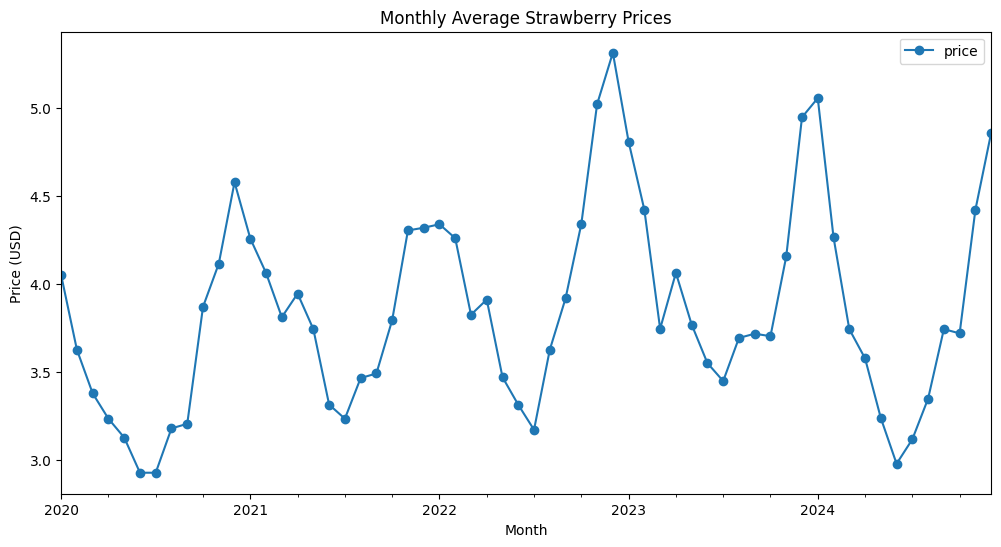

In [4]:
# Plot the data
df.plot(figsize=(12, 6), marker='o')
plt.title('Monthly Average Strawberry Prices')
plt.ylabel('Price (USD)')
plt.xlabel('Month')
plt.legend()
plt.show()

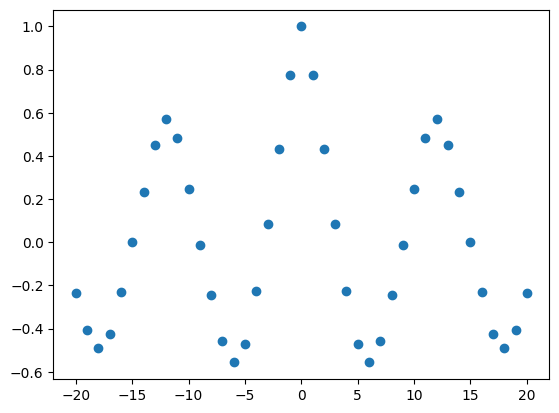

In [5]:
# Autocorrelations using pandas and matplotlib
plt.acorr(df['price'] - df['price'].mean(), maxlags=20, normed=True, usevlines=False)
None

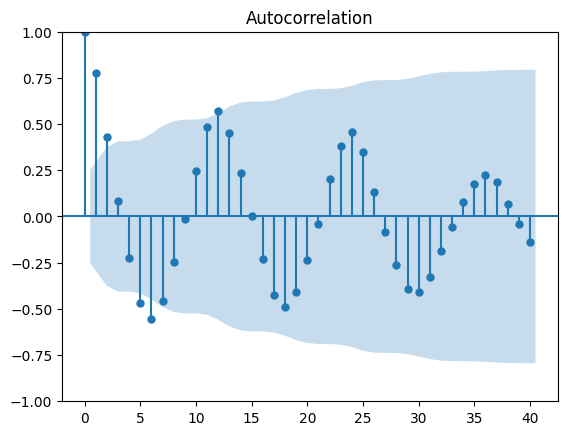

In [6]:
# Autocorrelations using statsmodels
tsaplots.plot_acf(df['price'], lags=40)
plt.show()

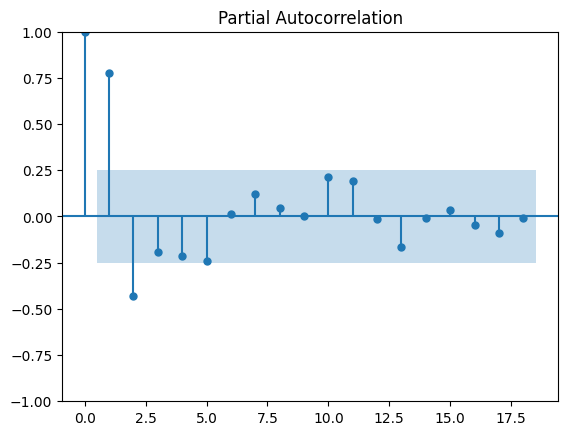

In [7]:
# Partial Autocorrelations using statsmodels
tsaplots.plot_pacf(df['price'])
plt.show()

In [8]:
# Split the data into training and testing sets
training_df = df[df.index <= '2023-12-01']
testing_df = df[df.index > '2023-12-01']

In [9]:
# Set up the frequency to be monthly
training_df.index.freq = 'MS'
testing_df.index.freq = 'MS'
df.index.freq = 'MS'

In [10]:
# Run an Autoregressive model using statsmodels
model = ar_model.AutoReg(training_df['price'],
                         lags=1,
                         seasonal=True,
                         period=12)
res = model.fit()

In [11]:
# Create predictions for the next 12 months
pred = res.predict(len(training_df), len(training_df) + 11)
pred

2024-01-01    4.635953
2024-02-01    4.310723
2024-03-01    3.865060
2024-04-01    3.928836
2024-05-01    3.640031
2024-06-01    3.366404
2024-07-01    3.267428
2024-08-01    3.548737
2024-09-01    3.629137
2024-10-01    3.964067
2024-11-01    4.428581
2024-12-01    4.813141
Freq: MS, dtype: float64

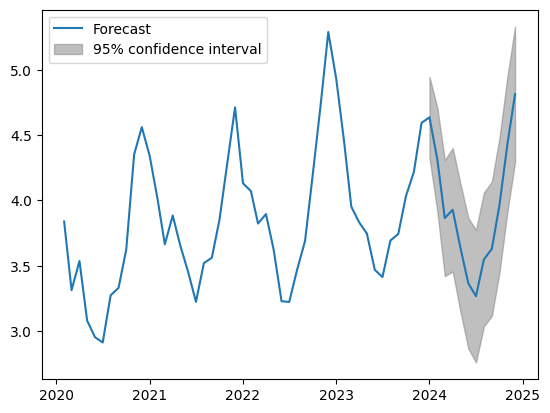

Root Mean Squared Error: 0.25


In [12]:
fig = res.plot_predict(start=0, end=len(training_df) + 11, dynamic=False)
plt.show()

# Calcualte the RMSE for the predictions
rmse = np.sqrt(mean_squared_error(testing_df['price'], pred))
print(f'Root Mean Squared Error: {rmse:.2f}')

In [13]:
# Store the predictions in a TSV file
pred_2024_df = pd.DataFrame(pred, columns=['price'], index=testing_df.index)
pred_2024_df.to_csv(r'submission\strawberry-backtest.tsv', sep='\t')

Submit "strawberry-backtest.tsv" in Gradescope.

## Part 2: Backtest Errors

What are the mean and standard deviation of the residuals between your backtest predictions and the ground truth? (If your mean is not close to zero, then you may be missing a long term trend.)

Write the mean and standard deviation to a file "backtest-accuracy.tsv" with two columns, mean and std.

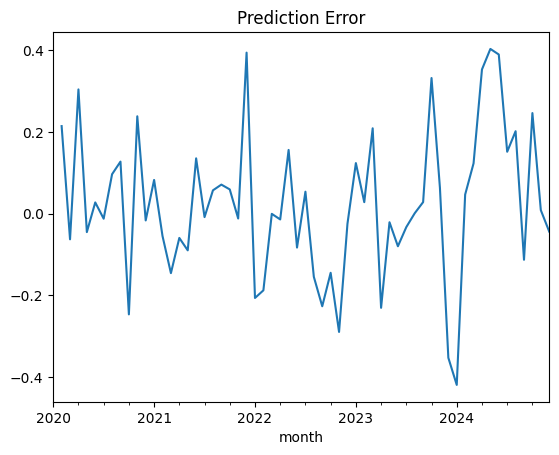

In [14]:
# Visualize the sample prediction error
df['predicted'] = res.predict(0, len(df)-1)
(df['predicted'] - df['price']).plot()
plt.title('Prediction Error')
plt.show()

In [15]:
# Caclulate the mean and std of the prediction error
error_mean = (pred_2024_df['price'] - testing_df['price']).mean()
error_std = (pred_2024_df['price'] - testing_df['price']).std()
print(f'Prediction Error Mean: {error_mean:.2f}, Std: {error_std:.2f}')

# Save the mean error and std error in a tsv file
error_df = pd.DataFrame({'mean': [error_mean], 'std': [error_std]})
error_df.to_csv(r'submission\backtest_accuracy.tsv', sep='\t')

Prediction Error Mean: 0.11, Std: 0.24


Submit "backtest-accuracy.tsv" in Gradescope.

## Part 3: Forecast Strawberry Prices

Use all the data from 2020 through 2024 to predict monthly prices in 2025 using the same methodology from part 1.
Make a monthly forecast for each month of 2025 and save it as "strawberry-forecast.tsv" with columns for month and price.

In [19]:
# Run an Autoregressive model using statsmodels
model_2 = ar_model.AutoReg(df['price'],
                         lags=1,
                         seasonal=True,
                         period=12)
res_2 = model_2.fit()

In [20]:
pred_2 = res_2.predict(len(df), len(df) + 11)
pred_2

2025-01-01    4.664852
2025-02-01    4.246826
2025-03-01    3.788903
2025-04-01    3.811150
2025-05-01    3.517350
2025-06-01    3.251600
2025-07-01    3.205171
2025-08-01    3.480998
2025-09-01    3.628441
2025-10-01    3.895228
2025-11-01    4.410407
2025-12-01    4.808182
Freq: MS, dtype: float64

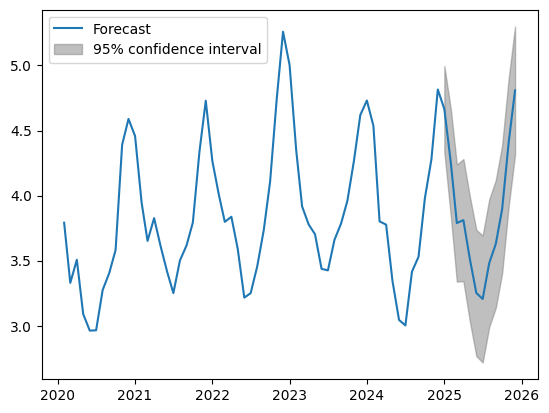

In [21]:
# visualize the predictions
fig = res_2.plot_predict(start=0, end=len(df) + 11, dynamic=False)
plt.show()

In [22]:
# Store the predictions in a TSV file
pred_2025_df = pd.DataFrame(pred_2, columns=['price'], index=pd.date_range(start='2025-01-01', periods=12, freq='MS'))
pred_2025_df.to_csv(r'submission\strawberry-forecast.tsv', sep='\t')

Submit "strawberry-forecast.tsv" in Gradescope.

## Part 4: Buy Low, Freeze and Sell High

Using your 2025 forecast, analyze the profit picking different pairs of months to buy and sell strawberries.
Maximize your profit assuming that it costs &dollar;0.20 per pint to freeze the strawberries, &dollar;0.10 per pint per month to store the frozen strawberries and there is a 10% price discount from selling previously frozen strawberries.
So, if you buy a pint of strawberies for &dollar;1, freeze them, and sell them for &dollar;2 three months after buying them, then the profit is &dollar;2 * 0.9 - &dollar;1 - &dollar;0.20 - &dollar;0.10 * 3 = &dollar;0.30 per pint.
To evaluate a given pair of months, assume that you can invest &dollar;1,000,000 to cover all costs, and that you buy as many pints of strawberries as possible.

Write the results of your analysis to a file "timings.tsv" with columns for the buy_month, sell_month, pints_purchased, and expected_profit.

In [17]:
# YOUR CHANGES HERE

...

Ellipsis

Submit "timings.tsv" in Gradescope.

## Part 5: Strategy Check

What is the best profit scenario according to your previous timing analysis?
How much does that profit change if the sell price is off by one standard deviation from your backtest analysis?
(Variation in the sell price is more dangerous because you can see the buy price before fully committing.)

Write the results to a file "check.tsv" with columns best_profit and one_std_profit.

In [18]:
# YOUR CHANGES HERE

...

Ellipsis

Submit "check.tsv" in Gradescope.

## Part 6: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgements.txt" in Gradescope.

## Part 7: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

Submit "project.ipynb" in Gradescope.